In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import wot

# Notebook 2: Computing transport matrices

In this notebook we compute transport matrices connecting each pair of time-points, and we examine the effect of each parameter on the solution. 

To compute the transport matrix $\pi_{t_1,t_2}$ connecting cells $x_1, \ldots, x_n$ at time $t_1$ to cells $y_1, \ldots, y_m$ at time $t_2$, we solve an optimization problem over all matrices $\pi$ that obey certain row-sum and column-sum constraints. 
These constraints ensure that the total amount of mass flowing out of each cell $x_i$ and into each cell $y_j$ adds up the correct amount. 
We select the transport matrix with the lowest possible transport cost, subject to these constraints. 

The amount of mass flowing out of each cell $x_i$ depends on the *growth rate* of the cell. We do this in step 1 below, before proceeding to computing transport maps in step 2. 


# Step 1: Construct initial estimate of cell growth rates (optional)

Before computing transport maps, we first form an initial estimate of the cell growth rate function $g(x)$. 
We do this using signatures of proliferation and apoptosis computed in Notebook 1. 
Note that we refine this initial estimate using unbalanced optimal transport, as explained later in this notebook. 

We model cellular growth with a Birth-Death Process, which assigns each cell $x$ a *rate* of division $\beta(x)$ and a  rate of death $\delta(x)$. 
In a small interval of time $dt$, these *rates* imply that the probability of a division is $\beta(x)dt$, and the probability of death is $\delta(x) dt$. 
The expected number of descendants after time $dt = t_2 - t_1$ is $e^{dt(\beta(x) - \delta(x))}$.

To compute the birth (i.e. division) rate and death rate, we apply a logistic function to transform the gene set scores into biologically plausible vaules for our reprogramming dataset (where the most proliferative cells double every 9 hours, and the least proliferative cells double every 60 hours). 

In [2]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('data/gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('data/growth_gs_init.txt')

# Step 2: Compute transport maps

We are now ready to compute transport maps. 

The next code block reads in the expression matrix, cell days, and the initial cell growth rates we computed in step 1 above. If the cell growth rates are not provided, the algorithm will assume each cell grows at roughly the same rate.  Note that the expression matrix we use here contains variable gene expression data of 1,400 genes from two time-course experiments, and we apply a filter to select cells from the serum time course. 

In [3]:
VAR_GENE_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = 'data/cell_days.txt'
SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
CELL_GROWTH_PATH = 'data/growth_gs_init.txt'

# load data
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

# The optimization problem

We solve the following *unbalanced transport* optimization problem introduced in Chizat et al 2018, where we only enforce the row-sum constraints approximately and we add entropy to the transport matrix: 

\begin{equation}
\begin{aligned}
\underset{\pi}{\text{minimize}} & \qquad \iint c(x,y) \pi(x,y) dx dy - \epsilon \int \pi(x,y) \log \pi(x,y) dx dy \\
&\qquad + \lambda_2 {\text{KL}} \left ( \int \pi(x,y) dx  \Big \vert d \hat {\mathbb{P}}_{t_2} (y) \int g(x)^{t_2 - t_1} d \hat {\mathbb{P}}_{t_1}(x) \right ) \\ 
& \qquad + \lambda_1 {\text{KL}} \left ( \int \pi(x,y) dy \Big \vert d \hat {\mathbb{P}}_{t_1} (x) g(x)^{t_2 - t_1} \right). 
\end{aligned}
\end{equation}

Here we use the notation  $\hat {\mathbb{P}}_{t_k} = \frac 1 n \sum_{i=1}^n \delta_{x_i}$ for the empirical distribution of samples $x_1,\ldots,x_n$ at time $t_k$, and $\text{KL}(P \vert Q)$ denotes the KL-divergence between distributions $P$ and $Q$. The function $c(x,y)$ encodes the cost of transporting a unit mass from $x$ to $y$. We define $c(x,y)$ to be the squared euclidean distance between cells in local PCA space. This PCA space is computed separately for each pair of time-points. Finally, the function $g(x)$ encodes the growth rate of cell $x$, and is used to specify the budget of descendant mass for each cell $x_i$ at time $t_1$. 

The optimization problem has three regularization parameters: 
* $\epsilon$ controls the degree of entropy in the transport map. 
A larger value gives more entropic descendant distributions, where cells are able to obtain more fates. 
* $\lambda_1$ controls the constraint on the row sums of $\pi_{t_1,t_2}$, which depend on the growth rate function $g(x)$ 
A smaller value of $\lambda_1$ enforces the constraints less strictly, which is useful when we do not have precise information about $g(x)$.
* $\lambda_2$ controls the constraint on the column sums of $\pi_{t_1,t_2}$.

In the following code block we initialize an OTModel, which is parameterized by $\epsilon, \lambda_1, \lambda_2$.

In [4]:
# create OTModel
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

We can now use the OTModel to compute transport maps between any pair of time-points. 

In [5]:
# Compute a single transport map from day 7 to 7.5
tmap_annotated = ot_model.compute_transport_map(7,7.5)

The object tmap_annotated is an annotated transport matrix, and tmap_annotated.X contains the actual numerical matrix. 
Both rows and columns are annotated with cell barcodes and cell growth rates (just along rows). These annotations are accessed as follows: 

In [6]:
# row annotations include cell growth rates
tmap_annotated.obs

# columns annotated by cell barcodes
# tmap_annotated.var

,g0,g1
index,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977589
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510199
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789104
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790364
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918584
D7_Dox_C1_AAACCTGCATATACGC-1,1.412582,1.366065
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.182596,1.144585
D7_Dox_C1_AAACCTGTCGGAATCT-1,0.982687,1.047557
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.417277,0.443068


The column `g0` displays the input growth rates and the column `g1` displays the row sums of the transport map (raised to the power $t_2 - t_1$. These values can differ, as we see in the plot below, because the row-sum constraints are only enforced loosely. We interpret the value `g1` as an *inferred growth rate*. 

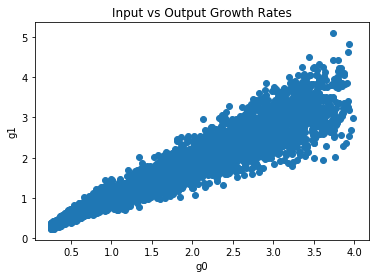

In [7]:
# Visualize how growth rates change with growth iterations
plt.scatter(tmap_annotated.obs['g0'],tmap_annotated.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

When we increase the regularization parameter $\lambda_1$, the row sum constraints are enforced more strictly. 

In [8]:
ot_model_strict = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 3,lambda2 = 50) 
tmap_anno_strict = ot_model_strict.compute_transport_map(7,7.5)

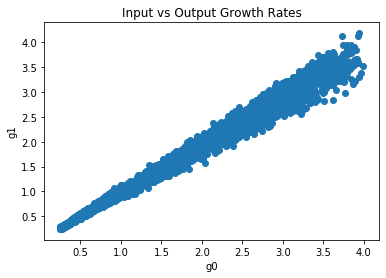

In [9]:
plt.scatter(tmap_anno_strict.obs['g0'],tmap_anno_strict.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

# Updating growth estimates

We can feed these new growth rates back into the OT solver and recompute transport maps with these new growth rates. Instead of doing this manually, we can specify the number of 'growth iterations' with the flag `growth_iters`.

In [10]:
ot_model_gr2 = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50,growth_iters=2) 
tmap_anno_gr2 = ot_model_gr2.compute_transport_map(7,7.5)

The row annotations of this transport map now have fields for multiple iterations of learning growth:

In [11]:
# row annotations include initial cell growth rates g0, and also g1 and g2
tmap_anno_gr2.obs

,g0,g1,g2
index,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977589,0.771923
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510199,2.130938
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789104,1.692330
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790364,2.516863
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918584,0.815139
D7_Dox_C1_AAACCTGCATATACGC-1,1.412582,1.366065,1.303655
D7_Dox_C1_AAACCTGCATCCGTGG-1,1.182596,1.144585,1.093318
D7_Dox_C1_AAACCTGTCGGAATCT-1,0.982687,1.047557,1.093740
D7_Dox_C1_AAACGGGGTAGTACCT-1,0.417277,0.443068,0.462439


# Tuning $\lambda_1$ and $\lambda_2$

The numerical value of $\lambda_1$ determines how different $g_{k+1}$ can be from $g_k$. If growth rates are known very well, then a large value of $\lambda_1$ can be used to enforce the row-sum constraints strictly and we could just do one growth iteration. When we do more than one growth iteration, the value of $\lambda_1$ can be interpreted intuitively as an *inverse step size* in our update of growth rates. A large value allows us to change growth by a lot at each iteration. 

You may have noticed that we set $\lambda_2 = 50$, a much larger numerical value than $\lambda_1 = 1$. This enforces the constraints on the column sums strictly (the amount of mass going into each cell $y$ at time $t_2$ is well specified). To see this, we plot a histogram of column sums, and we see a very narrow band. 

(array([   2.,    2.,   23.,   58.,  200.,  624., 1517., 1869.,  726.,
          40.]),
 array([1.404813 , 1.407358 , 1.4099029, 1.4124479, 1.4149928, 1.4175378,
        1.4200828, 1.4226277, 1.4251727, 1.4277176, 1.4302626],
       dtype=float32),
 <a list of 10 Patch objects>)

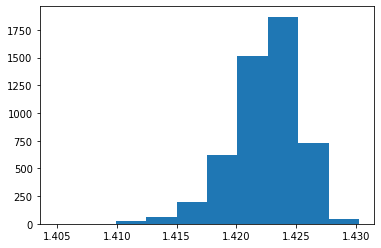

In [12]:
colsums = tmap_anno_gr2.X.sum(axis=0);
plt.hist(colsums)

# Tuning $\epsilon$ 

The parameter $\epsilon$ controls the level of entropy in the transport maps. A larger value promotes more entropic descendant distributions, so each cell can transition to a larger variety of descendants. We recommend sticking with the default value of $\epsilon = 0.05$. Note that we rescale the cost matrix to have a median value of $1,$ so the default value of $\epsilon$ should give similar results for datasets of different scales.  

# Compute all transport maps in batch mode

The following command computes all transport maps. Note that this can take a few hours on a laptop. For convenience, we include precomputed transport maps in the `tmaps` directory. 

In [13]:
# ot_model = wot.ot.OTModel(adata, epsilon = 0.05, lambda1 = 1, lambda2 = 50, growth_iters = 3) 
# ot_model.compute_all_transport_maps(tmap_out='tmaps/serum')

# we can speed this up by supplying g2 and doing 1 growth iter

This can also be run from the command line as follows:

`wot optimal_transport --matrix data/ExprMatrix.var.genes.h5ad --cell_days data/cell_days.txt --cell_filter data/serum_cell_ids.txt --cell_growth_rates data/growth_gs_init.txt --growth_iters 3 --lambda1 1 --lambda2 50 --epsilon 0.05`

We use these transport maps in the remaining notebooks. 